In [6]:
import pandas as pd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

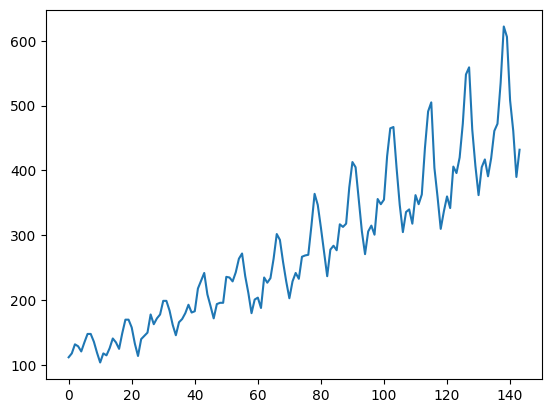

In [4]:
df = pd.read_csv("airline.csv")
timeseries = df[['passengers']].values.astype('float32')

plt.plot(timeseries)

In [5]:
train_size = int(len(timeseries)*0.8)
test_size = len(timeseries) - train_size
train , test = timeseries[:train_size] , timeseries[train_size:]

In [9]:

import torch
 
def create_dataset(dataset, lookback):

    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [15]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([112, 4, 1]) torch.Size([112, 4, 1])
torch.Size([25, 4, 1]) torch.Size([25, 4, 1])


In [22]:
import torch.nn as nn 

class passenger(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1 , hidden_size=50 , num_layers= 1 , batch_first=True)
        self.linear = nn.Linear(50 , 1)
        
    def forward(self , x):
        x , _ = self.lstm(x)
        x = self.linear(x)
        return x
    

In [32]:

import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = passenger()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print((y_pred, y_train))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

(tensor([[[0.2742],
         [0.3674],
         [0.3810],
         [0.3838]],

        [[0.2728],
         [0.3639],
         [0.3805],
         [0.3837]],

        [[0.2700],
         [0.3643],
         [0.3809],
         [0.3829]],

        [[0.2717],
         [0.3662],
         [0.3815],
         [0.3854]],

        [[0.2728],
         [0.3659],
         [0.3835],
         [0.3864]],

        [[0.2720],
         [0.3679],
         [0.3840],
         [0.3872]],

        [[0.2743],
         [0.3687],
         [0.3854],
         [0.3887]],

        [[0.2740],
         [0.3692],
         [0.3861],
         [0.3892]],

        [[0.2746],
         [0.3704],
         [0.3869],
         [0.3900]],

        [[0.2753],
         [0.3714],
         [0.3876],
         [0.3906]],

        [[0.2756],
         [0.3718],
         [0.3878],
         [0.3900]],

        [[0.2756],
         [0.3712],
         [0.3867],
         [0.3883]],

        [[0.2752],
         [0.3696],
         [0.3846],
      

KeyboardInterrupt: 

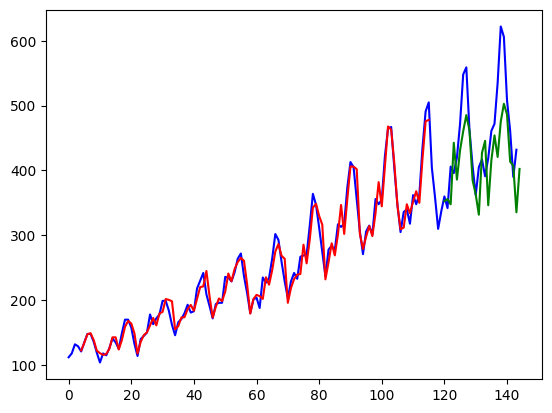

In [25]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()